In [1]:
import os
from torchvision import datasets, transforms, models
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import helper
train_transforms = transforms.Compose([transforms.Resize(100),
                                       transforms.CenterCrop(100),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.2205])])
valid_transforms = transforms.Compose([transforms.Resize(100),
                                       transforms.CenterCrop(100),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.2205])])
train_data = datasets.ImageFolder('train', transform=train_transforms)
test_data = datasets.ImageFolder('valid', transform=valid_transforms)
valid_data = datasets.ImageFolder('test', transform=valid_transforms)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\zchea/.torch\models\vgg16-397923af.pth
553433881it [01:24, 6582481.95it/s] 


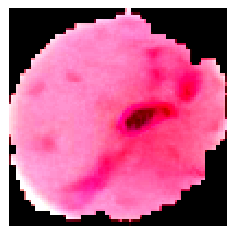

In [2]:

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)
images, labels = next(iter(trainloader))
#images, labels = trainloader
helper.imshow(images[0], normalize=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True)

In [5]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(nn.Linear(25088, 4096),
                                 nn.ReLU(),
                                 nn.Linear(4096, 2048),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(2048, 2),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.0005)
model.to(device)

epochs = 1
steps = 0
running_loss = 0
print_every = 10

for epoch in range(epochs):

    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs.cuda())
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {test_loss/len(validloader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 5.399.. Validation loss: 1.063.. Validation accuracy: 0.490
Epoch 1/1.. Train loss: 0.591.. Validation loss: 0.463.. Validation accuracy: 0.816
Epoch 1/1.. Train loss: 0.344.. Validation loss: 0.324.. Validation accuracy: 0.860
Epoch 1/1.. Train loss: 0.289.. Validation loss: 0.279.. Validation accuracy: 0.879
Epoch 1/1.. Train loss: 0.269.. Validation loss: 0.242.. Validation accuracy: 0.894
Epoch 1/1.. Train loss: 0.254.. Validation loss: 0.249.. Validation accuracy: 0.895
Epoch 1/1.. Train loss: 0.243.. Validation loss: 0.234.. Validation accuracy: 0.907
Epoch 1/1.. Train loss: 0.233.. Validation loss: 0.219.. Validation accuracy: 0.909
Epoch 1/1.. Train loss: 0.256.. Validation loss: 0.216.. Validation accuracy: 0.915
Epoch 1/1.. Train loss: 0.214.. Validation loss: 0.224.. Validation accuracy: 0.904
Epoch 1/1.. Train loss: 0.217.. Validation loss: 0.214.. Validation accuracy: 0.915
Epoch 1/1.. Train loss: 0.197.. Validation loss: 0.211.. Validation accuracy

In [6]:
def test(model,testset):
    correct = 0;
    total = 0;
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total = total + labels.size(0)
            correct = correct + (predicted == labels).sum().item()
    print((correct/total)*100)
model.to(device)
test(model,testloader)

92.85714285714286


In [7]:
model.class_to_idx = train_data.class_to_idx
checkpoint = {'input_size': 25088,
              'output_size': 102,
              'hidden_layers': [4096,2048],
              'class_to_idx': model.class_to_idx,
              'state_dict': model.classifier.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [ ]:
import os
from torchvision import datasets, transforms, models
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import helper
from PIL import Image
def predict(image_path, model, topk=5):
    testimage = Image.open(image_path)
    testimage = process_image(testimage)
    testimage = torch.from_numpy(testimage).type(torch.FloatTensor)
    testimage = testimage.unsqueeze(0)
    logps = model(testimage)
    #ps = torch.exp(logps)
    #top_p, top_class = ps.topk(topk)
    inv_class_idx = {v: k for k,v in model.class_to_idx.items()}
    probs, inds = torch.topk(torch.exp(logps), topk, sorted=True)    
    return [prob.item() for prob in probs[0].data], [inv_class_idx[i.item()] for i in inds[0].data]
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    checkpoint= torch.load(filepath, map_location=lambda storage, loc: storage) # load in CPU mode   
    model = models.vgg16(pretrained=True)
    model.classifier = nn.Sequential(nn.Linear(checkpoint['input_size'], checkpoint['hidden_layers'][0]),
                       nn.ReLU(),
                       nn.Linear(checkpoint['hidden_layers'][0], checkpoint['hidden_layers'][1]),
                       nn.ReLU(),
                       nn.Dropout(0.2),
                       nn.Linear(checkpoint['hidden_layers'][1], checkpoint['output_size']),
                       nn.LogSoftmax(dim=1))
    for param in model.parameters():
        param.requires_grad = False
    model.classifier.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model
def process_image(pil_image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    height = pil_image.height
    width = pil_image.width
    ratio_old = width/height
    new_height = 100
    new_width = 100
    NewSize = (int(new_width),int(new_height))
    pil_image.thumbnail(NewSize)
    np_image = np.array(pil_image)
    np_image = ((np_image/np_image.max())-mean)/std
    np_image = np_image.transpose((2,0,1))
    #return torch.from_numpy(np_image).type(torch.FloatTensor)
    return np_image

model = load_checkpoint("checkpoint.pth")
img_path = 'train' + '/4' + "/0ada12c0e78f.png"
top_p,top_c = predict(img_path,model)

In [9]:
print(top_p)
print(top_c)

[0.9959256649017334, 0.0040748510509729385]
['0', '1']
